# 1 Author

**Student Name : Kumar Ankur Anurag** 


# 2 Problem formulation

Using the entire ML Yummy dataset to build a model that takes the image and ingredients of a dish as Input and predicts whether the dish contains ingredients that cause common food allergy (categorised as contains_allergens in my model) or not (categorised as doesnot_contains_allergen in my model). The common food ingredient allergens list is obtained from the NHS website https://www.nhs.uk/conditions/food-allergy/

# 3 Machine Learning pipeline

**1.** Data pre-processing: The entire dataset is downloaded from the git repository and **split** into the **train, test set**, where each set consists of **a path to image file**, stored in **X_train_paths, X_test_paths** and **'Ingredients', 'Dish_name' text data stored in X_train, X_test**; I have **added another column 'allergens'** which contains the **labels contains_allergens/doesnot_contains_allergen based on the ingredients of the dish**. The 'allergens' column is **encoded (0 -"contains_allergens" and 1-"doesnot_contains_allergen")**, serving as my label(Y_train,Y_test) for both X_train and X_test datasets.

In [157]:
image_processing_pipeline

Pipeline(steps=[('image_pre_process',
                 FunctionTransformer(func=<function pre_processed at 0x1469a4a40>)),
                ('image_feature_selection',
                 FunctionTransformer(func=<function feature_extraction at 0x1426b0f40>))])

**2.a.** The **first Function transformer is the pre-processor**, where I modify the image by adding Black colour(without changing the aspect ratio) to **make it square, then resizing it to 200x200 pixels**. The **input** to this stage is the **path where the images are stored (X_train_paths)** and returns **an array of resized images**. \
**2.b.** The **second Function transformer is used for feature extraction**; I'm using the **Gabor filter and GMLC features** for image texture feature extraction. The **input** to this stage is **the pre-processed images**, and the function returns **features dimensionally reduced (to 6 features in new predictor space) in a numpy array representing features in numerical format**.
*The exact process is followed for X_test_paths in both transformers but instead of again fitting it to the transformer, we just transform the data based on the fitting parameters of the train dataset*

In [158]:
text_processing_pipeline

Pipeline(steps=[('token_matrix', CountVectorizer()),
                ('sparse_to_dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x15700dee0>)),
                ('PCA', PCA(n_components=15))])

**3.** I have used **CountVectorizer** to **extract individual ingredients** from the **ingredients texts for each dish** present in the dataset (**X_train, X_test**); since CountVectorizer returns a **sparse matrix of numerical features**, I have used a **custom Function Transformer to change it in the dense matrix**, then I'm using **PCA to reduce the dimensionality of features from 2826 to 15**. This stage's **output is an array with textual feature representation in numerical format. (X_train_text_features, X_train_text_features)**

**4.** I'm **combining** both the **image feature obtained in numpy array after image processing and the text feature also obtained in array format after text processing to generate a combined(using a UDF) dataset(X_train_combined, X_test_combined) on which I will build, train and deploy my ML model**.

In [159]:
pipeline


Pipeline(steps=[('scalar', StandardScaler()),
                ('classifier', LogisticRegression(C=0.1))])

**5.** The **X_train_combined, X_test_combined** are scaled to get **normalised values**. Then, I trained the **Random Forest Classifier, Linear Support Vector Classifier and Logistic regression classification model** on this dataset to **predict** the train and test dataset **labels(Y_train, Y_test)**.

# 4 Transformation stage

The transformation stage is divided in two parts:\
**1. Image Processing Stage**\
**2. Text Processing Stage**

**1.a. Pre-Processing Stage**

The main custom function is **pre_processed**, which clubs the pre-processed images in an array and is dependent on the following functions to perform specific tasks:
1. **make_it_square**:- used to make the image square by padding it with zeros along the shorter dimension.
2. **resize_img**:- use to combine the resize channel(of size 100x100) to the input image to produce the final image
3. **image_preprocessing**:- is a master function that makes use of make_it_square, resize_img to carry out transformation on input images and return the final image of size 200x200

**1.b.Feature Selection Stage**

Since each photo is described by 6x200x200 = 240000 values. Therefore, the predictor space has 240000 dimensions. Since our dataset is small, we are moving our samples from a **240000 dimensions** space to another with **six dimensions** using feature extraction. I'm using two functions, **gabor_features** and **GMLC_features**, that extract six image features that will define a new predictor space. I'm using the feature_extraction function, which combines the features extracted from the below-mentioned function in an array.\
i. **gabor_features**:- it uses the Gabor filter, a linear bandpass filter that does **texture analysis for images projected at a particular theta angle and frequency and attenuates other angles**. **To simplify feature selection**, I'm keeping **frequency constant, considering only the real part of the response and only varying the angle at **0, 45, 90 and 180 degrees** (converted to radian). In the particular selected angles, it converts the image in greyscale and computes the strength of filter response at a particular value of sigma (standard deviation) in 2D. \
ii. **GMLC_features**:- it uses **Grey Level Co-occurrence matrix** computes **two texture features, dissimilarity and co-relation** for a given input image

2. In the text processing stage, **CountVectorizer** is employed to convert the ingredients of each dish into a **sparse matrix**, where each **unique token corresponds to a column and represents a unique ingredient from the list of ingredients for each dish**. The result of CountVectorizer is a sparse matrix of **dimension (2275, 2826)**, as **observed feature columns are greater than the data row**, which will lead to the **overfitting of our model**. To avoid the situation, I have used **PCA(Principal Component Analysis) to reduce the dimension of features to 15**. Since the input format to the PCA module is a **dense matrix**, I have used a **custom function to convert the sparse matrix output of CountVectorizer to the dense matrix**.

# 5 Modelling

I have used three classification models: **RandomClassifier, Linaer SVC and Logistic Regression**; the reason is to **generate a benchmark result based on the selected feature parameters (both image and text combined)** generated in the Transformation step and **define which model is suitable to be used on the dataset and which gives the optimal result**. For tunning the Hyperparameters of these models, **as the data size is not very large, using large hyperparameters will make the model complex and increase computation requirements and likely to overfit the training data**, so by using the hit and trial method, I tweaked the **model parameter for better result, avoiding overfitting**.

# 6 Methodology

After splitting the data in the train-test set, I'm passing the paths of the stored images in X_train_paths, X_test_paths and the modified text data in X_train, X_test (obtained from TrainSet, TestSet) to the **image_processing_pipeline** and **image_processing_pipeline** respectively. These pipelines convert the image and text features into a dimensionally reduced numpy array of their equivalent numerical features(stored in **X_train_image_features, X_test_image_features, X_train_text_features, X_test_text_features** respectively). These features are combined to generate a single array of features **X_train_combined, X_test_combined**; the **X_train_combined datset** is used to **train the ML models**; the trained ML models are then used to make a **prediction** on **X_test_combined dataset**, whether the dish contains common food allergens or not. The benchmarks used for the performance analysis of the models are:

1. **Accuracy**
2. **Confusion Matrix**


In [1]:
pip install mlend --upgrade

Note: you may need to restart the kernel to use updated packages.


In [2]:
# necessary import
import mlend
from mlend import download_yummy, yummy_load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import skimage as ski
import spkit as sp

import os, glob
import re
import warnings
warnings.filterwarnings('ignore')

In [58]:
# sklearn library imports
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from skimage.feature import ORB
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from skimage.color import rgb2hsv, rgb2gray
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config
set_config(display = 'diagram')

# 7 Dataset

The following steps are involved in the data pre-processing:
1. I downloaded the data from the MLEnd yummy git repository and **stored the csv and images separately**
2. I created a function named **check_allergens**, which searches for the list of allergens mentioned in it with each dish's ingredients text; if it finds a match, it labels that dish as **"contains_allergen"** otherwise, it labels then as **"doesnot_contains_allergen"**
3. Using the custom function train_test, I **split** the data in **TrainSet TestSet** using the **Benchmark_A column as my split criteria**.
4. **Separated** the **image path** for both **TrainSet and TestSet** and **stored** it in **X_train_paths, X_test_paths** and **created a separate data frame X_train, X_test for text features like Ingredients and Dish_name.
5. Created a **new column, "allergens"**, which **contains contains_allergen/doesnot_contains_allergen labels derived from the Ingredients column** using the **function check_allergens**
6. Created **Y_train and Y_test encoded labels from the "allergens" (0 -"contains_allergens" and 1-"doesnot_contains_allergen") column to benchmark the performance of the trained ML models**.
7. Plotted **histogram** to show **how many dishes contain food allergens in both the Train and Test dataset**.

In [51]:
# downloading the entire yummy dataset
subset = {}

datadir = download_yummy(save_to = './MLEnd', subset = subset,verbose=1,overwrite=False)

In [4]:
# reading the csv and image path
MLENDYD_df = pd.read_csv('/MLEnd/yummy/MLEndYD_image_attributes_benchmark.csv').set_index('filename')
sample_path = '/MLEnd/yummy/MLEndYD_images/*.jpg'
files = glob.glob(sample_path)

In [52]:
# list of dir
os.listdir(datadir)

['MLEndYD_image_attributes_benchmark.csv',
 '.DS_Store',
 'MLEndYD_images',
 'MLEndYD_image_attributes_small.csv',
 'MLEndYD_images_small']

In [9]:
# udf for splitting train test data on basis of column 'Benchmark_A'
def train_test (datadir):
  return yummy_load(datadir_main=datadir,train_test_split='Benchmark_A')

In [79]:
# udf for extracting food ingredient which are considered as allergens and assigning them common label 'contains_allergen' and other ingredients as 'doesnot_contains_allergen'
def check_allergens(ingredient):
    allergens = ['milk', 'egg', 'peas', 'peanut', 'soy', 'fish', 'mustard', 'wheat', 'almonds', 'cashews','oats','bread']
    for allergen in allergens:
        match = re.compile(fr'\b{re.escape(allergen)}(?:\b|[_,])')
        if re.search(match,ingredient):
            return "contains_allergen"
    return "doesnot_contains_allergen"

In [80]:
# splitting the dataset using train_test function, splitting criteria based on column Benchmark_A
TrainSet, TestSet, Map = train_test(datadir)

# seperating the image paths and the text features in different variables
X_train_paths, X_train = TrainSet['X_paths'],TrainSet['Y'][['Ingredients','Dish_name']]
X_test_paths, X_test = TestSet['X_paths'],TestSet['Y'][['Ingredients','Dish_name']]

# creating new column in X_train, X_test using the check_allergens function
X_train['allergens'] = X_train['Ingredients'].apply(check_allergens)
X_test['allergens'] = X_test['Ingredients'].apply(check_allergens)

Total 3250 found in /Users/ankuranurag/Desktop/MLEnd/yummy/MLEndYD_images/


In [82]:
# creating a label encoder instance
le = LabelEncoder()

In [83]:
# creating encoded labels for train, test dataset
Y_train = le.fit_transform(X_train['allergens'])
Y_test = le.transform(X_test['allergens'])

In [81]:
# checking value counts based on created category
X_train['allergens'].value_counts()

doesnot_contains_allergen    1498
contains_allergen             777
Name: allergens, dtype: int64

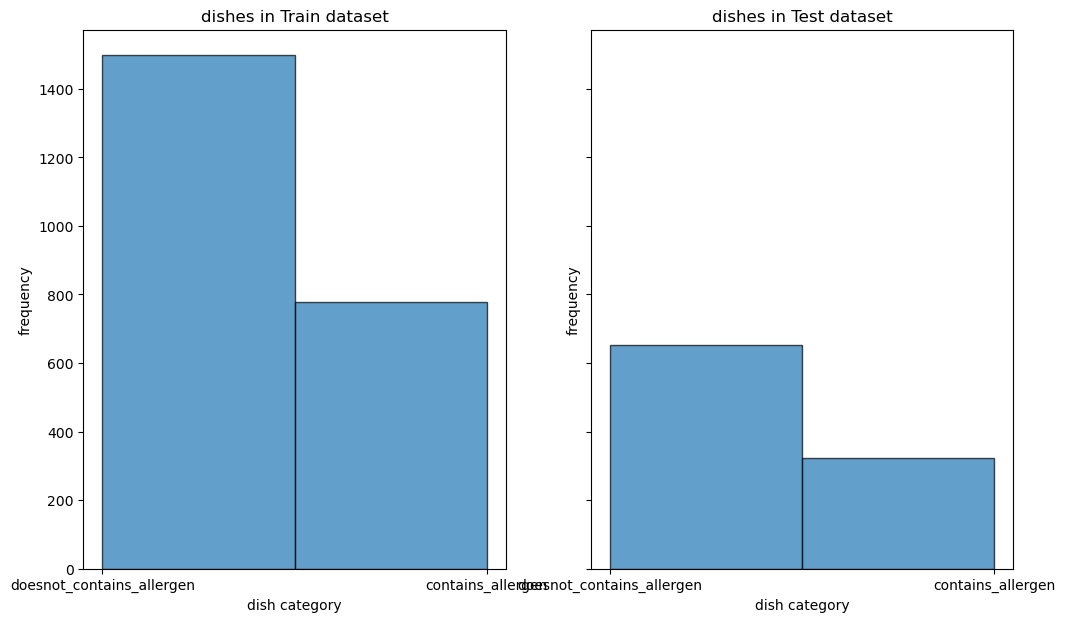

In [91]:
# plot showing dishes with and without allergen ingredients in train and test dataset
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7), sharex=True, sharey=True)
axes[0].hist(X_train['allergens'], bins = 2, edgecolor='black', alpha=0.7)
axes[0].set_title('dishes in Train dataset')
axes[0].set_xlabel('dish category')
axes[0].set_ylabel('frequency')

axes[1].hist(X_test['allergens'], bins = 2, edgecolor='black', alpha=0.7)
axes[1].set_title('dishes in Test dataset')
axes[1].set_xlabel('dish category')
axes[1].set_ylabel('frequency')
plt.show()

### Transformation Stage

### Image processing stage 
**a. Pre Processing Stage**

In [14]:
# udf for making the images square using padding
def make_it_square(I, pad=0):
  N,M,C = I.shape
  if N>M:
    Is = [np.pad(I[:,:,i], [(0,0),(0, N-M)], 'constant', constant_values=pad) for i in range(C)]
  else:
    Is = [np.pad(I[:,:,i], [(0, M-N),(0,0)], 'constant', constant_values=pad) for i in range(C)]

  return np.array(Is).transpose([1,2,0])

In [15]:
# udf for resizing the image
def resize_img(I,size=[100,100]):
  N,M,C = I.shape
  Ir = [sp.core.processing.resize(I[:,:,i],size) for i in range(C)]
  return np.array(Ir).transpose([1,2,0])

In [16]:
# udf for image preprocessing
def image_preprocessing (file, k, length):
  sp.utils.ProgBar_JL(k, length,L=50,color='blue')
  I = plt.imread(file)
  I = make_it_square(I, pad=0)
  I = resize_img(I,size=[200,200])
  return I

In [17]:
# udf for generating pre processed X_train, X_test (image)
def pre_processed(_paths):
  return np.array([image_preprocessing(file, k, len(_paths)) for k,file in enumerate(_paths)])

**b.Feature Selection Stage**

In [18]:
# udf for selecting feature using Gabor filters returns 4 features one for each thetas defined in the function
def gabor_features(I):
    Ig = rgb2gray(I)
    features = []
    thetas = [0, np.pi*0.25, np.pi*0.5, np.pi]
    for theta in thetas:
        real_part, img_part = ski.filters.gabor(Ig, frequency=1, theta = theta, sigma_x=10, sigma_y=10)
        features.append(np.mean(real_part))
    return features

In [19]:
# udf for getting GMLC features (dissimilarity and corelation)
def GMLC_features(I):
    Ig = (rgb2gray(I)*255).astype('uint8')
    glcm = graycomatrix(Ig, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    f1 = graycoprops(glcm, 'dissimilarity')[0, 0]
    f2 = graycoprops(glcm, 'correlation')[0, 0]
    return f1,f2

In [84]:
# udf for creating confusion matrix
def showConfMat(CM, labels = ['contains_allergen','doesnot_contains_allergen']):
  plt.matshow(CM,cmap='Blues')
  for i in range(CM.shape[0]):
    for j in range(CM.shape[1]):
      plt.text(i,j,CM[i,j].round(2),ha='center',)
  plt.xticks([0,1],labels)
  plt.yticks([0,1],labels)
  plt.show()

In [21]:
# udf for images based feature selection
def feature_extraction(data):
    return np.array([[*gabor_features(I), *GMLC_features(I)] for I in data])

In [26]:
# creating an image function transformer for the pre_processed function
image_preprocessor_transformer = FunctionTransformer(pre_processed, validate= False)

In [27]:
# creating an image function transformer for the feature_extraction function
image_feature_selection = FunctionTransformer(feature_extraction, validate= False)

In [28]:
# combining pre processing and feature selection steps to create pipeline for image processing
image_processing_pipeline = Pipeline([
    ('image_pre_process', image_preprocessor_transformer),
    ('image_feature_selection', image_feature_selection)
])

In [31]:
# generating and storing equivalent numerical features of the image features obtained from image processing
X_train_image_features = image_processing_pipeline.fit_transform(X_train_paths)
X_test_image_features = image_processing_pipeline.transform(X_test_paths)

100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|2275\2275|
Done!
100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|975\975|
Done!


**The above step runs sequentially for each images will take around an hr for completion**

### Text Processing Stage

In [34]:
# creating a CountVectorizer and PCA instances
cv = CountVectorizer()
pca = PCA(n_components=15)

In [37]:
# combining vectorization, matrix conversion and dimensionality reduction steps to create pipeline for text processing
text_processing_pipeline = Pipeline([
    ('token_matrix', cv),
    ('sparse_to_dense', FunctionTransformer(lambda x:x.toarray(), accept_sparse=True)),
    ('PCA', pca)
])

In [38]:
# generating and storing equivalent numerical features of the text features obtained from text processing
X_train_text_features = text_processing_pipeline.fit_transform(X_train['Ingredients'])
X_test_text_features = text_processing_pipeline.transform(X_test['Ingredients'])

### Main Code

In [43]:
# udf for combining numerical features obtained from image and text processing
def combine_features(image_features, text_features):
    return np.hstack((image_features, text_features))

In [44]:
# generating combined features
X_train_combined = combine_features(X_train_image_features, X_train_text_features)
X_test_combined = combine_features(X_test_image_features, X_test_text_features)

In [45]:
# creating a standard scalar instance
scalar = StandardScaler()

### Machine Learning Pipelines

In [108]:
# combining normalisation and using Linear SVC model steps to build the pipeline
pipeline = Pipeline([
    ('scalar', scalar),
    ('classifier', LinearSVC(C=0.1))
])

In [150]:
# fitting the pipeline with training data present at X_train_combined and Y_train labels
pipeline.fit(X_train_combined, Y_train)

Pipeline(steps=[('scalar', StandardScaler()),
                ('classifier', LogisticRegression(C=5))])

In [110]:
# testing the model by making prediction of the labels based on the Training data (0 -"contains_allergens" and 1-"doesnot_contains_allergen")
ytp_lsvc = pipeline.predict(X_train_combined)

# input to the model the dataset (image and text combined) of the dish whose label is to be predicted (stored in X_test_combined)
ysp_lsvc = pipeline.predict(X_test_combined)

In [111]:
# calculating accuracy of the Linear SVC model on both Y_train and Y_test
train_accuracy_lsvc = np.mean(ytp_lsvc==Y_train)
test_accuracy_lsvc  = np.mean(ysp_lsvc==Y_test)

In [126]:
# combining normalisation and using Random Forest Classifier model steps to build the pipeline
pipeline = Pipeline([
    ('scalar', scalar),
    ('classifier', RandomForestClassifier(n_estimators=25,max_depth=3, random_state=42))
])

In [149]:
# fitting the pipeline with training data present at X_train_combined and Y_train labels
pipeline.fit(X_train_combined, Y_train)

Pipeline(steps=[('scalar', StandardScaler()),
                ('classifier', LogisticRegression(C=5))])

In [128]:
# testing the model by making prediction of the labels based on the Training data
ytp_rf = pipeline.predict(X_train_combined)


# input to the model the dataset (image and text combined) of the dish whose label is to be predicted (stored in X_test_combined)
ysp_rf = pipeline.predict(X_test_combined)

In [129]:
# calculating accuracy of the RandomForestClassifier model on both Y_train and Y_test
train_accuracy_rf = np.mean(ytp_rf==Y_train)
test_accuracy_rf  = np.mean(ysp_rf==Y_test)

In [151]:
# combining normalisation and using Logistic Regression steps to build the pipeline
pipeline = Pipeline([
    ('scalar', scalar),
    ('classifier', LogisticRegression(C=0.1))
])

In [152]:
# fitting the pipeline with training data present at X_train_combined and Y_train labels
pipeline.fit(X_train_combined, Y_train)

Pipeline(steps=[('scalar', StandardScaler()),
                ('classifier', LogisticRegression(C=0.1))])

In [153]:
# testing the model by making prediction of the labels based on the Training data
ytp_lr = pipeline.predict(X_train_combined)


# input to the model the dataset (image and text combined) of the dish whose label is to be predicted (stored in X_test_combined)
ysp_lr = pipeline.predict(X_test_combined)

In [154]:
# calculating accuracy of the Logistic Regression model on both Y_train and Y_test 
train_accuracy_lr = np.mean(ytp_lr==Y_train)
test_accuracy_lr  = np.mean(ysp_lr==Y_test)

# 8 Results

**1. LinearSVC**:- I selected LinearSVC model with the regularisation/trade-off parameter(c) set to 0.1, as for higher parametric hyperparameter values of 1, 10 and 20, the trend indicated that the accuracy test data set was slightly higher (by1-2%) than the accuracy of training data (75%) it can be due to non-sync between processed training data and the algorithm of the model or may be due to the size of the dataset. Since the dataset is not very large, using a small value of c gives a simpler decision boundary.

Accuracy Result of the Model

In [113]:
print('Training Accuracy:\t',train_accuracy_lsvc )
print('Test  Accuracy:\t',test_accuracy_lsvc)

Training Accuracy:	 0.7630769230769231
Test  Accuracy:	 0.7661538461538462


Confusion Matrix to observe the per-class accuracies

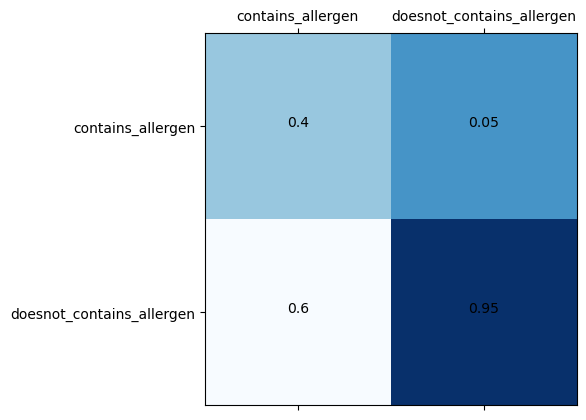

In [114]:
Ac = np.mean(ysp_lsvc[Y_test.astype(int)==0]==0)
Ar = np.mean(ysp_lsvc[Y_test.astype(int)==1]==1)

Mc = np.mean(ysp_lsvc[Y_test.astype(int)==0]==1)
Mr = np.mean(ysp_lsvc[Y_test.astype(int)==1]==0)

CM = np.array([[Ac, Mc],[Mr, Ar]])

showConfMat(CM)

**Observation**

1. The model can predict whether a new image of the dish contains an allergen ingredient or not with 76.6% accuracy
2. The model can identify actual food allergens present with a recall of 40%, while it identifies actual dish which doesn't contain any common food allergen with a recall of 95%

**2. RandomForestClassifier**:- I selected the number of individual decision trees (estimators) as 25 as after 25 trees, there was not any significant improvement in the label prediction (contains allergens or doesnot contains allergens) on both the train and test data which remained around 77% and 76% respectively. Similar was the scenario with the number of levels (depth) of each decision tree. Upon increasing the depth from 3, no significant improvement was observed. Initially, I tried with 15 decision trees and kept the depth at 3; the accuracy on the train dataset was around 75%, and that of the test dataset was 74%.

Accuracy Result of the Model

In [130]:
print('Training Accuracy:\t',train_accuracy_rf )
print('Test  Accuracy:\t',test_accuracy_rf)

Training Accuracy:	 0.7613186813186813
Test  Accuracy:	 0.7569230769230769


Confusion Matrix to observe the per-class accuracies

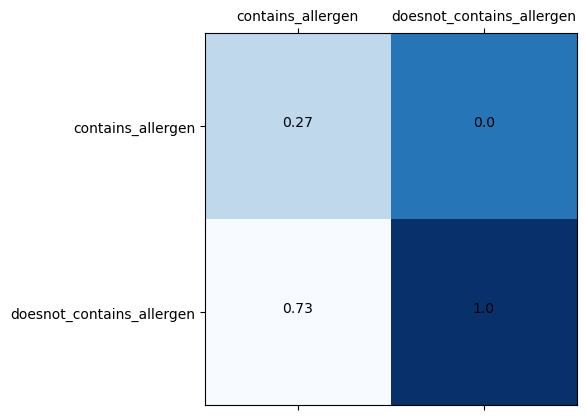

In [131]:
Ac = np.mean(ysp_rf[Y_test.astype(int)==0]==0)
Ar = np.mean(ysp_rf[Y_test.astype(int)==1]==1)

Mc = np.mean(ysp_rf[Y_test.astype(int)==0]==1)
Mr = np.mean(ysp_rf[Y_test.astype(int)==1]==0)

CM = np.array([[Ac, Mc],[Mr, Ar]])

showConfMat(CM)

**Observation**

1. The model can predict whether a new image of the dish contains an allergen ingredient or not with 75.6% accuracy
2. The model can identify actual food allergens present with a recall of 27%, while it identifies actual dish which doesn't contain any common food allergen with a recall of 100%
3. Looking at the confusion matrix, it can be observed that the model is labelling dishes with no common food allergens as containing food allergens more frequently (0.73)

**3. LogisticRegression**:- For LogisticRegression, I have used the values of the inverse of the regularization strength parameter (c) as 0.1, 1, and 10; the trend of the result obtained is similar to the results obtained from the Linear LVC model, test set accuracy is slightly greater than train set accuracy, this can be due to the size of the dataset as a small number of data points are available for training the model.

Accuracy Result of the Model

In [155]:
print('Training Accuracy:\t',train_accuracy_lr)
print('Test  Accuracy:\t',test_accuracy_lr)

Training Accuracy:	 0.7608791208791209
Test  Accuracy:	 0.7651282051282051


Confusion Matrix to observe the per-class accuracies

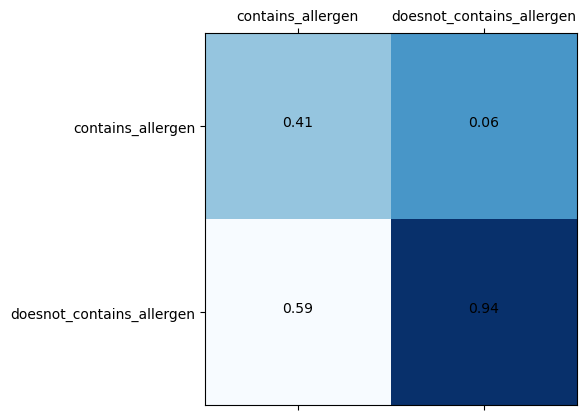

In [156]:
Ac = np.mean(ysp_lr[Y_test.astype(int)==0]==0)
Ar = np.mean(ysp_lr[Y_test.astype(int)==1]==1)

Mc = np.mean(ysp_lr[Y_test.astype(int)==0]==1)
Mr = np.mean(ysp_lr[Y_test.astype(int)==1]==0)

CM = np.array([[Ac, Mc],[Mr, Ar]])

showConfMat(CM)

**Observation**

1. The model can predict whether a new image of the dish contains an allergen ingredient or not with 76.5% accuracy
2. The model can identify actual food allergens present with a recall of 41%, while it identifies actual dish which doesn't contain any common food allergen with a recall of 94%

# 9 Conclusions

1. Of all the models trained,Linear SVC and LogisticRegression Model produced similar results. Random Forest Classifier has a 100% recall for dishes that don't contain any food allergens. I'm using 21 featured (6 images, 15 text) datasets in all three models to carry out my predictions.Also, for all the three models percentage of dishes tag as doesnot_contain_allergens but they actually do is very minimal.

2. Increasing the image features dimension increases the accuracy on the whole training and test dataset significantly; for example, initially, I considered 3 features in Gabor filter by taking 3 values of thetas(0,90,180) for image feature extraction, for the Random Forest models accuracy came around 65% on train set and 60% on test set but when I increased the features in Gabor filter to 4 (thetas 0,45,90,180) the accuracy came around 76 and 75 on the train and test data respectively for the same model.

3. I can adjust the strength of the filter response (magnitude) of the Gabor Filter by varying the sigma value (standard deviation) in 2D; this adjustment depends upon the size of the feature to be extracted. If the feature size is small, sigma's will be small and vice versa. In my case, I used sigma values(x,y) of 15 as my feature size was large in the Rice/chips pipeline, but here, I need to find individual ingredients for my model to classify them as food allergens or not; I got the optimal result for sigma values of 10 as it gives me a slightly narrower Gaussian envelope to detect the slight variation in the features of the train, test dataset.

4. The dataset is highly biased (below code) as it contains more dishes that don't contain any allergens than those which contain allergens; an unbiased dataset would have produced better recall for the latter.

In [160]:
# checking value counts based on created category
X_train['allergens'].value_counts()

doesnot_contains_allergen    1498
contains_allergen             777
Name: allergens, dtype: int64